In [1]:
# Set notebook to use only one GPU
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


# Model

After pre-processing is complete and the data has been stored in a file, load data and train the model.

The format of the data is a np array of shape (total_runs_from_all_subjects, n_channels, n_timestamps)

Which translates to (5184, 22, 1125) for this dataset and these params.

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras
from keras_uncertainty.models import StochasticClassifier
from models_bachelors import *
from file_functions import *
import time
import tensorflow as tf
from numpy import floor
from numpy import random
import keras_tuner as kt
dataset = load('all_subject_runs')
loaded_inputs = dataset['inputs']
loaded_targets = dataset['targets']
print(tf.config.list_physical_devices())

Using TensorFlow backend


Keras Uncertainty will use standalone Keras backend

bogos binted
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Lockbox Creation

**RQ:** Is Uncertainty of MCDropout better than MCDropConnect when generalizing cross-subject?
How to find: Get entropy distributions for correct and incorrect predictions on test subject
             then see which method has better distinguishing capabilities between correct
             and incorrect. If the distributions are very distinct, then you could use the 
             entropy (uncertainty) to get a handle of accuracy of a prediction.
             Ideally, it would be nice to do k-fold for each subject and get uncertainty
             distributions for each subject. Because then you're 'truly' generalizing
             cross-subject (using model trained on N subjects to test on M subjects).
             And you could see how the distributions are different for each subject and
             see that the UQ methods for some subjects are bad but for others its good.

Use 1 subject as Final test set.
Use remaining 8 subjects as train/val


**Current Experiment Setup:** For each of the three models (MCDropout, MCDropConnect and standard), perform k-fold cross validation on all subjects and get metrics and entropies (not for standard) for each subject (obtained from testing set which is 1 subject). 

Then for the two methods, plot a distribution of entropies for each subject. See if there's a huge distinction in the distributions for incorrect and correct predictions. If there is, then you can conclude that for some subjects, entropy is a good estimator for accuracy. Then or all 3 methods, plot accuracy.

**TO-DO:** 
- Train/val on only a single subject for both methods. Get the best model from that and train the rest of the subjects.
    
    

# Hyperparameter Tuning

In [ ]:
n_epochs= 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [early_stopping]
# There's an error in MCDropConnect so it's out of the list for now
methods = ['mcdropout', 'mcdropconnect']
subject_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8]
drop_rates = dict.fromkeys(methods, 0)

# Training loop for MCDropout and MCDropconnect models
for method in methods:
    # This loop leaves one subject for testing (denoted by the number in the name of the weights file).
    # Then it combines all the subject trials such that shape is now (8 * 576, 22, 1125).
    # Then selects 10% of this as the validation set.
    subject_id = 0
    train_ids = subject_ids[:]
    train_ids.remove(subject_id)
    train_inputs = np.vstack(loaded_inputs[train_ids])
    train_targets = np.vstack(loaded_targets[train_ids])        
    X_train, X_val, Y_train, Y_val = train_test_split(train_inputs, train_targets, test_size=0.1)
    # Do hyperparam tuning (SUBJECT 0)
    best_model = tune_model(X_train, X_val, Y_train, Y_val, method, callbacks)

In [4]:
# Finding tuning results

mcdropout_tuner = kt.GridSearch(build_dropout_model,
                    objective='val_loss',
                    max_trials=100,
                    directory=f'mcdropout/tuning',
                    project_name='untitled_project')

mcdropconnect_tuner = kt.GridSearch(build_dropconnect_model,
                    objective='val_loss',
                    max_trials=100,
                    directory=f'mcdropconnect/tuning',
                    project_name='untitled_project')

mcdropout_tuner.reload()
mcdropconnect_tuner.reload()
dropout_best_hps = mcdropout_tuner.get_best_hyperparameters(num_trials=1)[0]
dropconnect_best_hps = mcdropconnect_tuner.get_best_hyperparameters(num_trials=1)[0]


# 0.2 is optimal for both

Reloading Tuner from mcdropout/tuning/untitled_project/tuner0.json
Reloading Tuner from mcdropconnect/tuning/untitled_project/tuner0.json


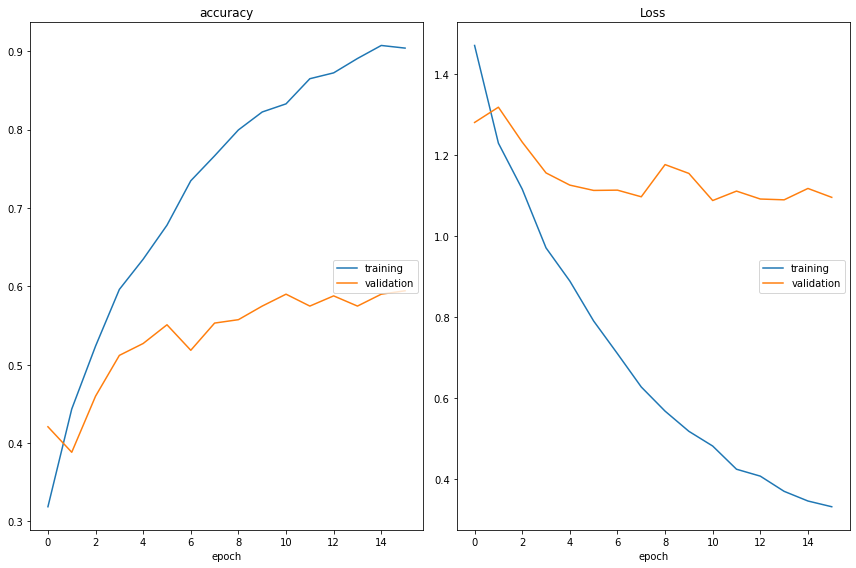

accuracy
	training         	 (min:    0.319, max:    0.907, cur:    0.904)
	validation       	 (min:    0.388, max:    0.594, cur:    0.594)
Loss
	training         	 (min:    0.331, max:    1.471, cur:    0.331)
	validation       	 (min:    1.088, max:    1.319, cur:    1.096)
130/130 [==============================] - 70s 540ms/step - loss: 0.3315 - accuracy: 0.9040 - val_loss: 1.0959 - val_accuracy: 0.5944
Epoch 1/100
 82/130 [=================>............] - ETA: 25s - loss: 1.4400 - accuracy: 0.3346

In [5]:
'''
CHECK EVERY PART OF THE TRAINING LOOP! VALIDATION AND TRAINING ACCURACY IS OVER 80% IN THE FIRST EPOCH!!!
AND LOSS IS BELOW 0.5 IN THE FIRST EPOCH!! SOMETHING IS DEFINITELY WRONG! 
'''

n_epochs= 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# There's an error in MCDropConnect so it's out of the list for now
methods = ['mcdropout', 'mcdropconnect']
subject_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# So I need to: tune hyperparams only once (and save the weights) for the first subject.
# Then for every other subject I need to use the best hyperparams and train the others.
# For this I need to pass the chosen drop_rates to existing_model() if drop_rates is not None


# Training loop for MCDropout and MCDropconnect models. Basically K-fold CV
for method in methods:
    directory = f'{method}/weights'
    with safe_open_w(f'{directory}/training_info_{method}.txt') as file:
        file.write(f'METHOD_NAME:{method}\n NUMBER_EPOCHS:{n_epochs}\n NUMBER_SUBJECTS:{9}\n NUMBER_SPLITS:{9}\n')
    
    # This loop leaves one subject for testing (denoted by the number in the name of the weights file).
    # Then it combines all the subject trials such that shape is now (8 * 576, 22, 1125).
    # Then selects 10% of this as the validation set.
    for subject_id in subject_ids:
        checkpoint_path = f'{directory}/test_subject_{subject_id}.ckpt'
        saving_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
        train_ids = subject_ids[:]
        train_ids.remove(subject_id)
        train_inputs = np.vstack(loaded_inputs[train_ids])
        train_targets = np.vstack(loaded_targets[train_ids])        
        X_train, X_val, Y_train, Y_val = train_test_split(train_inputs, train_targets,test_size=0.1)
        
        model = mcdropout_tuner.hypermodel.build(dropout_best_hps) if method == 'dropout' else mcdropconnect_tuner.hypermodel.build(dropconnect_best_hps)
        history = model.fit(X_train, Y_train, epochs=n_epochs, validation_data=[X_val, Y_val],
                           callbacks=[early_stopping, saving_callback, PlotLossesKeras()])
                

In [ ]:
print(4)